In [1]:

#LIBRARIES
import pandas as pd
import numpy as np

from dotenv import load_dotenv
import os

#ML LIBRARIES
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#PLOTING LIBRARIES
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style


#DATA REQUESTING LIBRARIES
import quandl
from yahoofinancials import YahooFinancials
import intrinio_sdk

#NN LIBRARIES
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM



Using TensorFlow backend.


In [35]:
# GETS THE API KEY FROM .ENV FILE
def get_key(d_key):
    
    load_dotenv('.env')
    key = os.environ.get(d_key)
    return key


# GETS DATA FROM QUANDL / DEFAULT IS BOING DATA 
def quandl_get(code="EOD/BA", start_date="1970-01-01", end_date="2019-05-30"):
    
    return quandl.get(code, start_date=start_date, end_date=end_date)


# GETS DATA FROM YAHOOFINANCIALS
def yahoo_get(ticker='AAPL', start='1970-01-01', end='2019-05-30'):
    yahoo_financials = YahooFinancials(ticker)
    dic = yahoo_financials.get_historical_price_data(start, end, 'daily')
    df = pd.DataFrame(dic[ticker]['prices'])
    return df


# KEEP SIGNIFICANT COLUMNS. ADD CHANGE AND VOLATILITY
def feature_eng_quandl(df, n=10):
    df['Volatility'] = (df['Adj_High'] - df['Adj_Low']) / df['Adj_Low']
    df['Change'] = (df['Adj_Close'] - df['Adj_Open']) / df['Adj_Open']
    df = df[['Adj_Close', 'Volatility', 'Change', 'Adj_Volume']]
    df['50ma'] = df['Adj_Close'].rolling(window=50, min_periods=0).mean()
    df.fillna('-999999', inplace=True) # N/A value treated as outlier
    #Defines forecast to predict
    forecast_column = 'Adj_Close'
    #shifts label to the past n days
    df['future_price{}d'.format(n)] = df[forecast_column].shift(-n)
    return df


# KEEP SIGNIFICANT COLUMNS. ADD CHANGE AND VOLATILITY
def feature_eng_yahoo(df, n=10):
    df.index = df['formatted_date']
    df['Volatility'] = (df['high'] - df['low']) / df['low']
    df['Change'] = (df['close'] - df['open']) / df['open']
    df = df[['close', 'Volatility', 'Change', 'volume']]
    df.columns = ['Adj_Close', 'Volatility', 'Change', 'Adj_Volume']
    df['50ma'] = df['Adj_Close'].rolling(window=50, min_periods=0).mean()
    df.fillna('-999999', inplace=True) # N/A value treated as outlier
    #Defines forecast to predict
    forecast_column = 'Adj_Close'
    #shifts label to the past n days
    df['future_price{}d'.format(n)] = df[forecast_column].shift(-n)
    return df    
 
    
#PLOTS CORRELATION HEATMAP AND SAVES
def plot_corr(df,size=10, title = 'Correlation'):
    style.use('ggplot')
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax = sns.heatmap(corr, annot=True, cmap="Blues").set_title(title)
    fig.savefig('images/corr_heatmap.png')

    
#TRAIN LINEAR REGRESSION 
def LSTM_train(data):
    df = data.dropna()
    X = df.drop('future_price10d', axis=1)
    y = df['future_price10d']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=4, batch_size=1, verbose=2)
    score, acc = model.evaluate(X_test, y_test,batch_size=batch_size)
    print('''----- * SCORE & ACCURACY * -----\n\nScore: {}%  Accuracy: {}%
          \n\n----- * SCORE & ACCURACY * -----'''.format(round(score*100,2), round(acc*100,2)))
    return model, score, acc



#TRAIN LINEAR REGRESSION 
def LR_train(data):
    df = data.dropna()
    X = df.drop('future_price10d', axis=1)
    y = df['future_price10d']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    reg = LinearRegression(n_jobs=-1)
    reg.fit(X_train, y_train)
    score = reg.score(X_test, y_test)
    print('----- * SCORE * -----\n\n{}%\n\n----- * SCORE * -----'.format(round(score*100,2)))
    return score, reg



#PREDICT FUTURE VALUES
def LR_predict(df, reg ,n=10):
    X = df.drop('future_price10d', axis=1)
    X_predict = X[-n:]
    predictions = reg.predict(X_predict)
    len(df)
    prediction_column = [np.nan for _ in range(len(df)-10)]
    prediction_column.extend(predictions)
    df['Predictions'] = prediction_column
    return predictions, df


#PLOT STOCK PRICE VS TIME
def plot_stock(df, col, size=10, title='Stock'):
    fig = plt.figure(figsize=(size,size))
    ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1, sharex=ax1)
    fig.suptitle(title)
    ax1.plot(df.index, df['Adj_Close'])
    ax1.plot(df.index, df['50ma'])
    ax2.bar(df.index, df['Adj_Volume'])
    plt.show()
    fig.savefig('images/{}.png'.format(title))

#PLOT PREDICTIONS
def plot_predictions(df, col, size=10, title='Stock'):
    style.use('ggplot')
    fig = df[col][-30:].plot( figsize=(size,size)).set_title(title).get_figure()
    fig.savefig('images/{}.png'.format(title))
    
#!!!! train lstm model !!!!

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


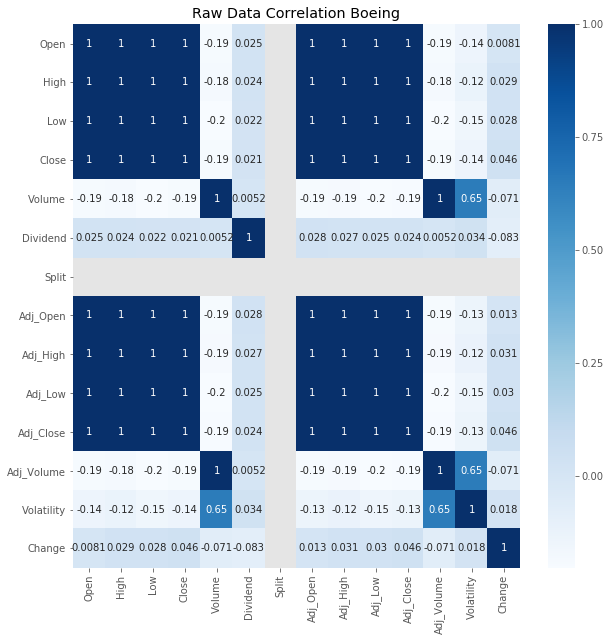

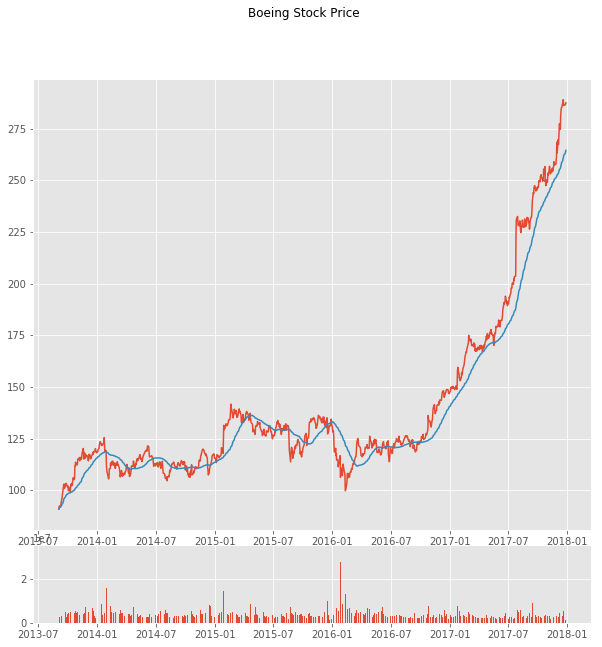

----- * SCORE * -----

97.88%

----- * SCORE * -----


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/p

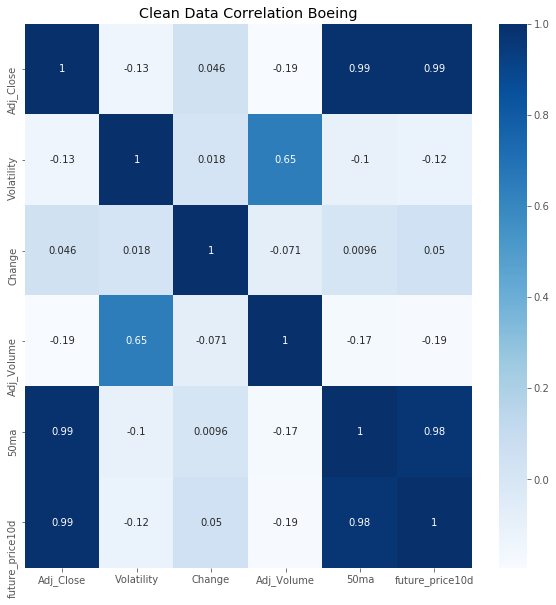

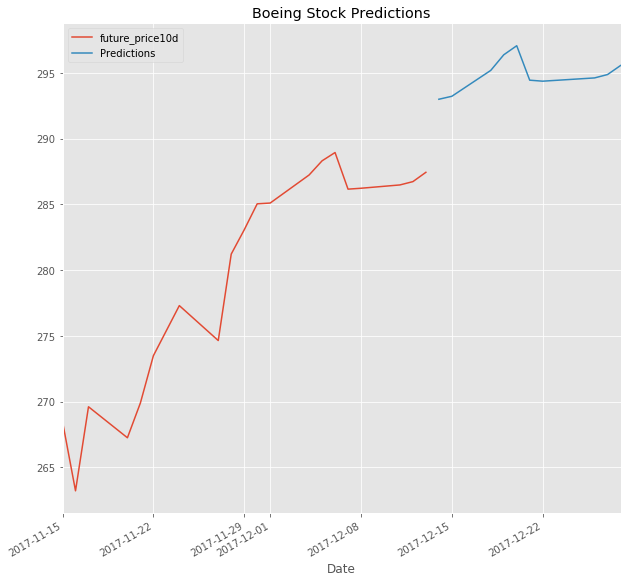

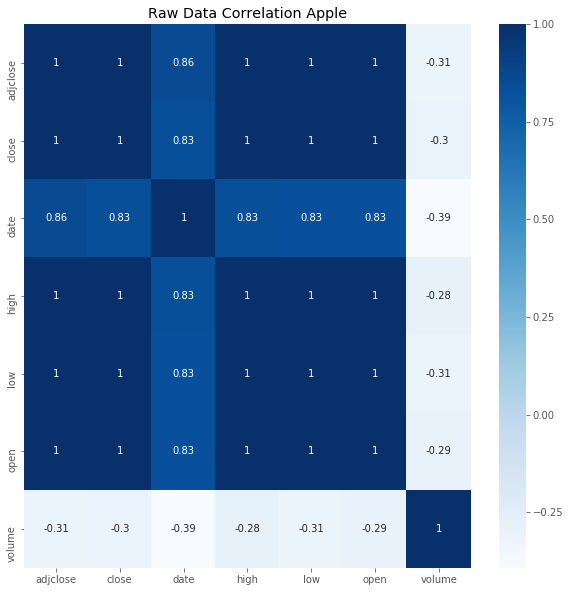

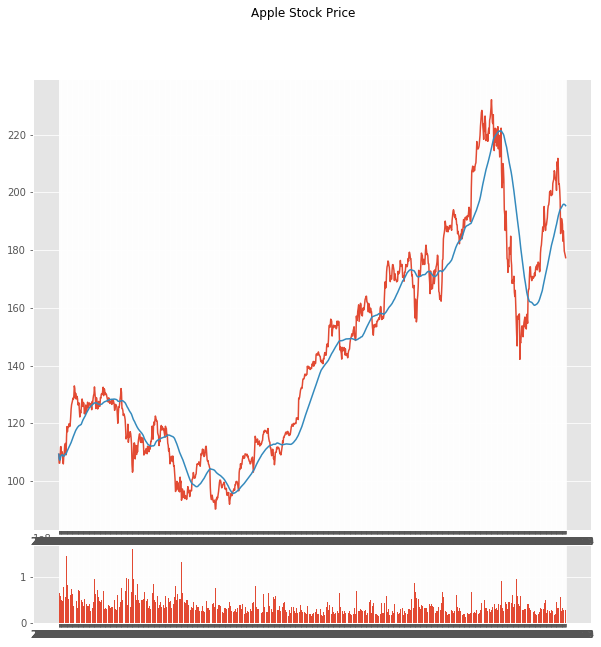

----- * SCORE * -----

95.97%

----- * SCORE * -----


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


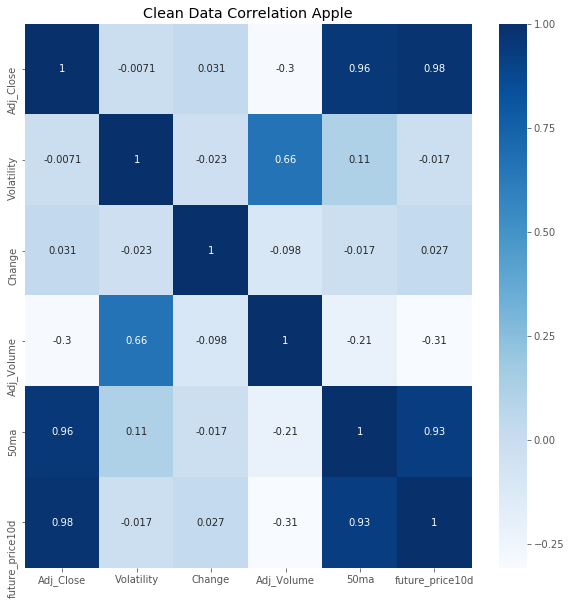

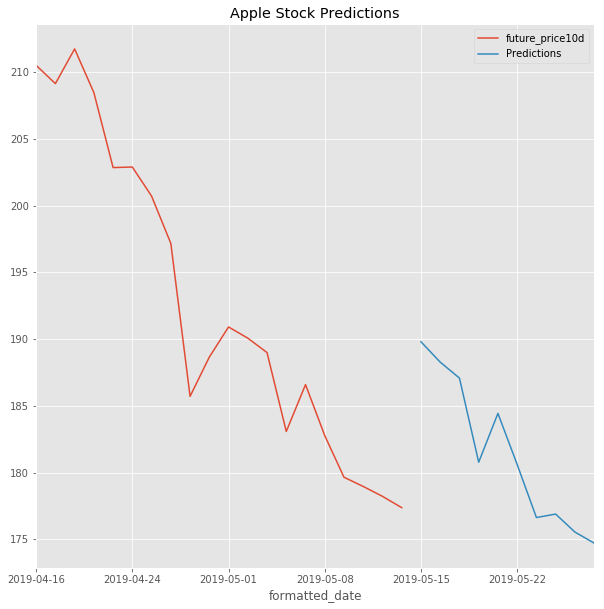

In [37]:
if __name__ == "__main__":
    
    #Define the forecast that the model is train to predict
    days_predict = 10
    
    #Request Quandl for the BOEING COMPANY historic data
    quandl_key = get_key('quandl_key')
    quandl.ApiConfig.api_key = quandl_key
    #boeing = quandl_get()
    
    #Plot data and feature correlation, clean data and featurure engineering
    plot_corr(boeing, 10, 'Raw Data Correlation Boeing')
    boeing_clean = feature_eng_quandl(boeing, days_predict)
    plot_stock(boeing_clean, 'Adj_Close',10,'Boeing Stock Price')
    plot_corr(boeing_clean, 10,'Clean Data Correlation Boeing')
    
    #Train model and predict Close Stock Prices BA
    score_boeing, reg_boeing = LR_train(boeing_clean)
    predictions_boeing, boeing_predicted = LR_predict(boeing_clean, reg_boeing, days_predict)
    plot_predictions(boeing_predicted,['future_price10d', 'Predictions'] , 10, 'Boeing Stock Predictions')
    
    #Request YahooFinance library for GOOGLE's historic data
    apple = yahoo_get('AAPL', '2015-01-01', '2019-05-30')
    plot_corr(apple, 10, 'Raw Data Correlation Apple')
    apple_clean = feature_eng_yahoo(apple)
    plot_stock(apple_clean, 'Adj_Close',10,'Apple Stock Price')
    plot_corr(apple_clean, 10,'Clean Data Correlation Apple')
    
    #Train model and predict Close Stock Prices AAPL
    score_apple, reg_apple = LR_train(apple_clean)
    predictions_apple, apple_predicted = LR_predict(apple_clean, reg_apple, days_predict)
    plot_predictions(apple_predicted,['future_price10d', 'Predictions'] , 10, 'Apple Stock Predictions')

In [ ]:

#LSTM_train(apple_clean)

In [38]:
boeing_clean.tail(15)

,Adj_Close,Volatility,Change,Adj_Volume,50ma,future_price10d,Predictions
Date,,,,,,,
2017-12-07,273.488601,0.025162,0.012496,4259441.0,254.491344,286.155768,NaN
2017-12-08,277.300390,0.013260,0.003123,4440341.0,255.131435,286.223663,NaN
2017-12-11,274.642807,0.023544,-0.010657,4065242.0,255.719531,286.475842,NaN
2017-12-12,281.218871,0.017656,0.006177,5357513.0,256.404805,286.728022,NaN
2017-12-13,283.061721,0.021229,0.004613,5002634.0,257.137162,287.436064,NaN
2017-12-14,285.040359,0.014422,0.004237,3912592.0,257.903304,NaN,292.990999
2017-12-15,285.098555,0.014845,-0.007127,6932943.0,258.610219,NaN,293.216685
2017-12-18,287.232381,0.008896,0.003592,2901145.0,259.365791,NaN,295.185697
2017-12-19,288.308993,0.011554,0.003037,2680754.0,260.146562,NaN,296.370373


In [39]:
apple_clean.tail(15)

,Adj_Close,Volatility,Change,Adj_Volume,50ma,future_price10d,Predictions
formatted_date,,,,,,,
2019-05-08,202.899994,0.017794,0.004953,26339500,193.0738,182.779999,NaN
2019-05-09,200.720001,0.025526,0.001597,34908600,193.5908,179.660004,NaN
2019-05-10,197.179993,0.031540,-0.001216,41208700,194.0714,178.970001,NaN
2019-05-13,185.720001,0.036259,-0.010601,57430600,194.2864,178.229996,NaN
2019-05-14,188.660004,0.023138,0.012070,36529700,194.5426,177.380005,NaN
2019-05-15,190.919998,0.030803,0.024964,26544700,194.8504,NaN,189.810011
2019-05-16,190.080002,0.019223,0.000895,33031400,195.1616,NaN,188.285064
2019-05-17,189.000000,0.022167,0.011074,32879100,195.4916,NaN,187.088609
2019-05-20,183.089996,0.022576,-0.002343,38612300,195.6952,NaN,180.785678
